torch.Size([1, 224, 224])
tensor(0.1255) tensor(0.9882)


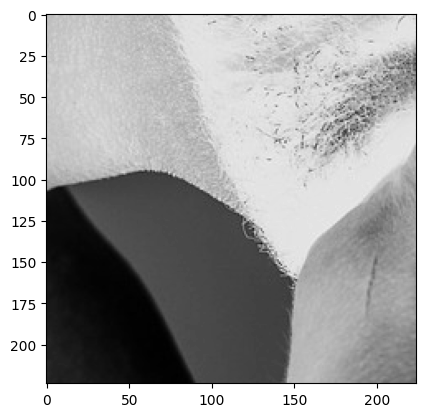

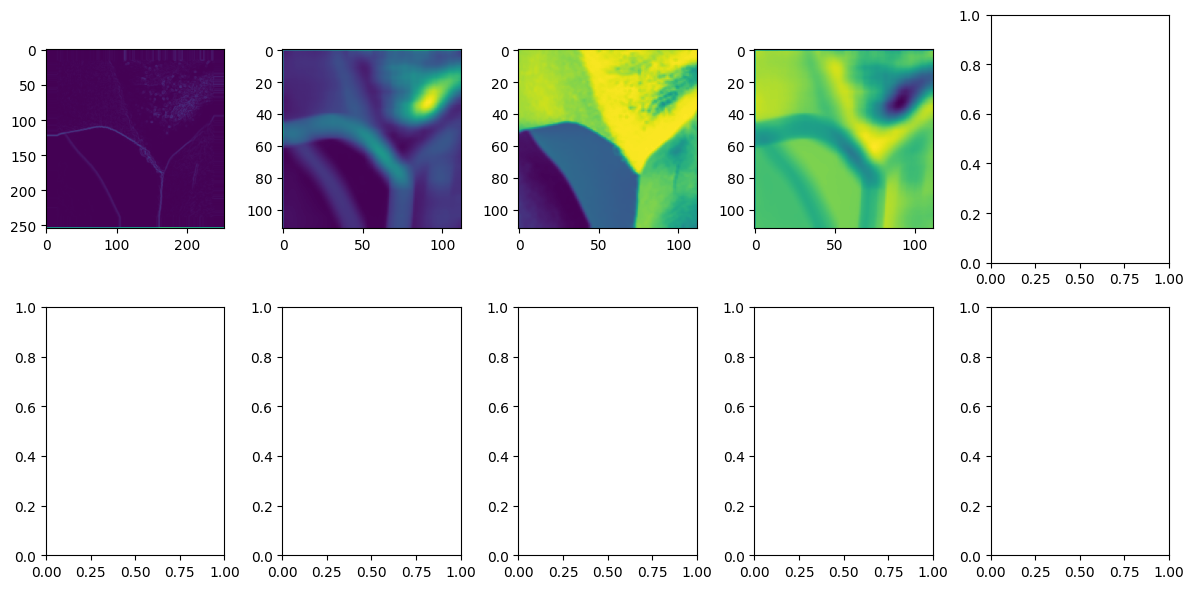

RuntimeError: The size of tensor a (254) must match the size of tensor b (224) at non-singleton dimension 3

In [45]:
import torch.nn as nn
import torch
import pytorch_lightning as pl
from utils import  get_sobel_kernel, get_gaussian_kernel, load_letter_conv_weights, get_rel_area_letters
from models import CustomTransposedConv2d
import matplotlib.pyplot as plt
import math


class LetterFilter(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.device = config["device"]
        self.letter_conv_k = config["letter_conv_k"]
        self.letter_conv_stride = config["letter_conv_stride"]
        sobel_k = config["sobel_k"]
        gauss_sig = config["gauss_sig"]
        font_path = config["font_path"]
        letters = config["letters"]
        self.num_letters = len(letters)
        self.letters_per_pix = config["letters_per_pix"]
        gauss_k = self.letter_conv_k
        self.eps = config["eps"]

        self.letter_size_alpha = config["letter_size_weight"]
        self.detail_beta = config["detail_weight"]
        self.overlap_gamma = config["overlap_gamma"]

        # sobel edge filter
        # https://towardsdatascience.com/implement-canny-edge-detection-from-scratch-with-pytorch-a1cccfa58bed
        with torch.no_grad():
          sobel_2D = get_sobel_kernel(sobel_k)
          self.sobel_filter_x = nn.Conv2d(in_channels=1,
                                          out_channels=1,
                                          kernel_size=sobel_k,
                                          padding=sobel_k //2,
                                          bias=False)
          self.sobel_filter_x.weight[:] = torch.from_numpy(sobel_2D)


          self.sobel_filter_y = nn.Conv2d(in_channels=1,
                                          out_channels=1,
                                          kernel_size=sobel_k,
                                          padding=sobel_k //2,
                                          bias=False)
          self.sobel_filter_y.weight[:] = torch.from_numpy(sobel_2D.T)

          #gaussian fitler after sobel
          gaussian_2D = get_gaussian_kernel(gauss_k, 0, gauss_sig)
          self.gaussian_filter = nn.Conv2d(in_channels=1,
                                          out_channels=1,
                                          kernel_size=gauss_k,
                                          stride=self.letter_conv_stride,
                                          bias=False)
          self.gaussian_filter.weight[:] = torch.from_numpy(gaussian_2D)

          # letter convolutions
          letter_conv_weights = load_letter_conv_weights(font_path, self.letter_conv_k, letters)
          self.letter_filter = nn.Conv2d(in_channels=1,
                                        out_channels=self.num_letters,
                                        kernel_size=self.letter_conv_k,
                                        stride=self.letter_conv_stride)
          self.letter_filter.weight[:] = letter_conv_weights

          # letter areas
          self.letter_conv_areas = get_rel_area_letters(font_path, self.letter_conv_k, letters)


          # transposed convs for mask
          transposed_convs_weights = load_letter_conv_weights(font_path, self.letter_conv_k, letters)
          transposed_padding = self.letter_conv_k // 2
          transpose_out_padding = self.letter_conv_stride -1 
          self.transp_conv = CustomTransposedConv2d(transposed_convs_weights,
                                                    self.num_letters,
                                                      1,
                                                        self.letter_conv_k,
                                                          self.letter_conv_stride,
                                                            transposed_padding,
                                                              transpose_out_padding)
        
        
    def forward(self, input_img: torch.Tensor):
        B, _, H, W = input_img.shape # C will be 1
        
        # pad input image
        input_img = nn.ReplicationPad2d(self.letter_conv_k//2)(input_img)

        _, _, H_letter_hits, W_letter_hits = self.gaussian_filter(torch.randn_like(input_img)).shape

        max_letter_hits_total = B * H_letter_hits * W_letter_hits
        grad_x = torch.zeros((B, 1, H, W)).to(self.device)
        grad_y = torch.zeros((B, 1, H, W)).to(self.device)
        grad_magnitude = torch.zeros((B, 1, H, W)).to(self.device)
        detail_map = torch.zeros((B, 1, H_letter_hits, W_letter_hits)).to(self.device)
        letter_hits = torch.zeros((B, self.num_letters, H_letter_hits, W_letter_hits)).to(self.device)
        # tracks letter hits pixels with max letter per pix reached, 0 = max reached
        filled_pixels = torch.ones((B, 1, H_letter_hits, W_letter_hits)).to(self.device)

        letter_match = torch.zeros((B, self.num_letters, H_letter_hits, W_letter_hits)).to(self.device)
        letter_areas = torch.zeros((B, self.num_letters, H_letter_hits, W_letter_hits)).to(self.device)        
        current_img = input_img.clone()

        # grad
        grad_x = self.sobel_filter_x(input_img)
        grad_y = self.sobel_filter_y(input_img)
        grad_magnitude = (grad_x ** 2 + grad_y ** 2) ** 0.5
        # normalize to [0,1]
        grad_max = grad_magnitude.max()
        grad_magnitude = grad_magnitude / grad_max if grad_max > 0 else grad_magnitude

        # blurr gradient image
        detail_map = self.gaussian_filter(grad_magnitude)
        # normalize to [0,1]
        grad_blurr_max = detail_map.max()
        detail_map = detail_map / grad_blurr_max if grad_blurr_max > 0 else detail_map


        # letter areas
        letter_areas = self.letter_conv_areas.view(1, self.num_letters, 1, 1).expand(B, self.num_letters, H_letter_hits, W_letter_hits)

        # letter matches
        letter_match : torch.Tensor = self.letter_filter(current_img)
        # letter hits total
        letter_hits_total = torch.sum(filled_pixels == 0)

        

        while torch.any(letter_match > self.eps) and letter_hits_total < max_letter_hits_total:
            # TODO work on this line
            weighted_letter_match = letter_match.mul(torch.abs(self.letter_size_alpha *letter_areas - self.detail_beta * detail_map))

            fig, axes = plt.subplots(2, 5, figsize=(12,6))
            axes.flat[0].imshow(grad_magnitude.detach()[0][0])
            axes.flat[1].imshow(detail_map.detach()[0][0])
            axes.flat[2].imshow(letter_match.detach()[0][0])
            axes.flat[3].imshow(letter_match.detach()[0][33])
            axes.flat[3].imshow(weighted_letter_match.detach()[0][33])
            plt.tight_layout()
            plt.show()

            indices = torch.argmax(weighted_letter_match.view(B, -1), dim=1, keepdim=True)
            mask = torch.zeros_like(weighted_letter_match.view(B, -1))
            mask = mask.scatter(1, indices, 1)
            mask = mask.view(B, self.num_letters, H_letter_hits, W_letter_hits)
            # add max letter hit of image of current iteration to all letterhits
            letter_hits = letter_hits + mask.mul(letter_match)

            # set filled pixels to 0 in filled pixels mask
            filled_pixels = (letter_hits > 0).sum(dim=1, keepdim=True) < self.letters_per_pix

            # update current image: substract found best letter from input img TODO make this negative?
            current_img = torch.clip(input_img - self.transp_conv(letter_hits), torch.tensor(0.), torch.tensor(1.))

            # letter matches
            letter_match = self.letter_filter(current_img)
            # set pixel with reached max letters per pix to zero
            letter_match = letter_match.mul(filled_pixels)

            # letter hits total
            letter_hits_total = torch.sum(filled_pixels == 0)
        
        return letter_hits, self.transp_conv(letter_hits).clip(torch.tensor(0.), torch.tensor(1.))

from data import get_img_transforms_train, get_img_transforms_train_target, BigImagesDataset,  get_img_transforms_test, get_img_transforms_test_target, BigImagesDataModule
import config.config as configFile
from utils import convert_rgb_tensor_for_plot, convert_gray_tensor_for_plot


train_transforms = get_img_transforms_train(224)
train_target_transforms = get_img_transforms_train_target(224)
ds_train = BigImagesDataset(str(configFile.TRAINING_IMGS_DIR), train_transforms, train_target_transforms)

in_img, target, label = ds_train[100]
plt.imshow(convert_gray_tensor_for_plot(in_img.unsqueeze(0)).squeeze(0).squeeze(0), cmap="gray")
print(ds_train[0][0].shape)
print(target.min(), target.max())

config = {
    "device": "cpu",
    "letter_conv_k": 31,
    "letter_conv_stride": 2,
    "sobel_k": 3,
    "gauss_sig": 1,
    "font_path": str(configFile.FONT_PATH),
    "letters":  configFile.TYPEWRITER_CONFIG["letterList"],
    "letters_per_pix": 1,
    "eps": 0.05,
    "letter_size_weight": 1,
    "detail_weight": 1,
    "overlap_gamma": 1,
}

letter_filter = LetterFilter(config)
letter_hits, out_img = letter_filter.forward(in_img.unsqueeze(0))

plt.imshow(out_img.detach().squeeze(0).squeeze(0))



torch.Size([1, 224, 224])
tensor(0.1216) tensor(1.)


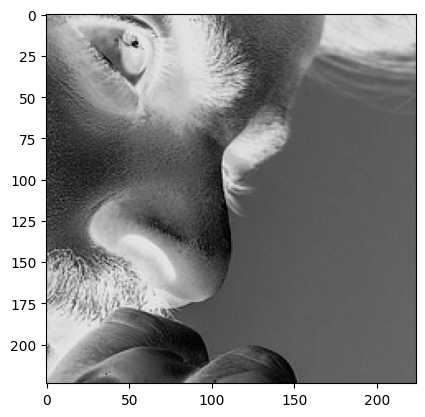

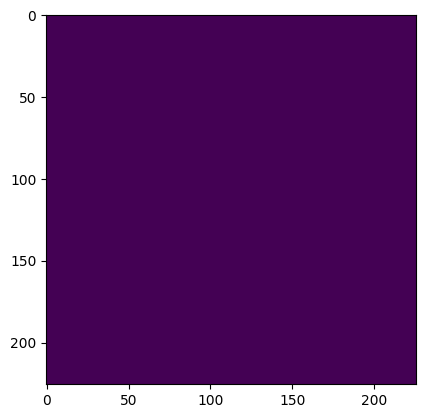

In [10]:
config = {
    "device": "cpu",
    "letter_conv_k": 31,
    "letter_conv_stride": 2,
    "sobel_k": 3,
    "gauss_sig": 1,
    "font_path": str(configFile.FONT_PATH),
    "letters":  configFile.TYPEWRITER_CONFIG["letterList"],
    "letters_per_pix": 1,
    "eps": 0.05,
    "letter_size_weight": 1,
    "detail_weight": 1,
    "overlap_gamma": 1,
}

letter_filter = LetterFilter(config)
letter_hits, out_img = letter_filter.forward(in_img.unsqueeze(0))

plt.imshow(out_img.detach().squeeze(0).squeeze(0))